In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from statsmodels.tsa.seasonal import STL 

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

Import dataset.

In [2]:

ETF_NAME = 'CERN'
if os.uname()[1]=='amethyst': ETF_DIRECTORY = '/home/acrnjar/Desktop/TEMP/GitHub_Local/data_for_xgboost_finan/Data/Stocks/'
if os.uname()[1]=='auros': ETF_DIRECTORY = '/home/alessandro/Documents/GitHub_Local/data_for_xgboost_finan/Data/Stocks/'
df = pd.read_csv(os.path.join(ETF_DIRECTORY, ETF_NAME.lower() + '.us.txt'), sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))
df.head()


,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-01-04,20.940,21.103,20.713,21.068,3058908,0
1,2010-01-05,21.355,22.345,21.250,22.313,7324724,0
2,2010-01-06,22.500,22.873,22.265,22.548,6844460,0
3,2010-01-07,22.423,22.750,22.230,22.680,2968936,0
4,2010-01-08,22.578,22.663,22.345,22.633,3238372,0


Visualize time series.

In [3]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

Decompose time series into trend, periodicity, and remainder.

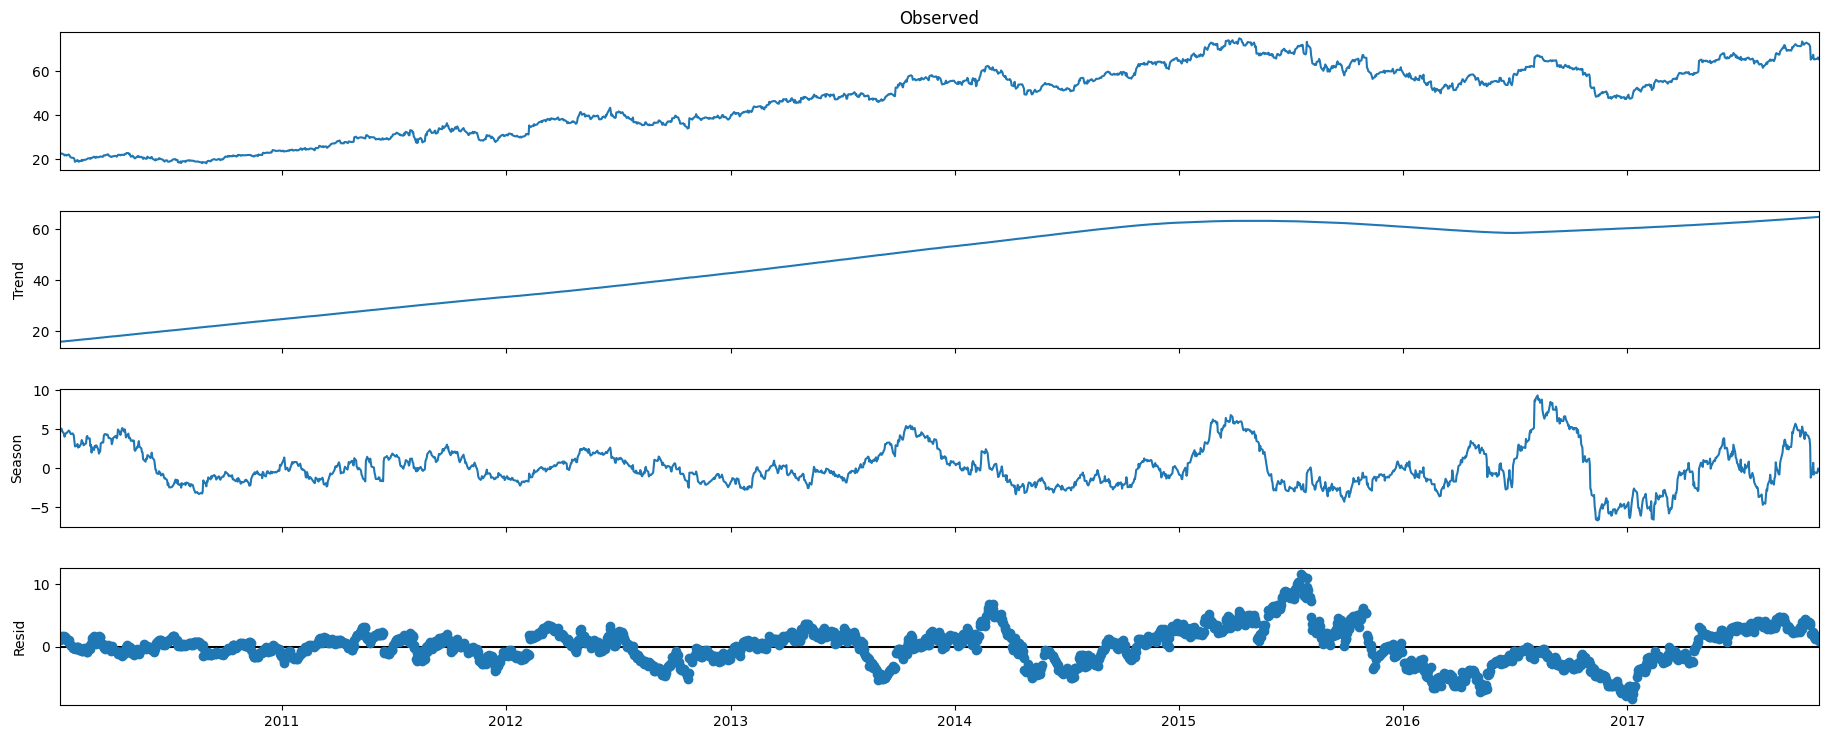

In [9]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()
decomp = STL(df_close, period=365)
res = decomp.fit()
fig = res.plot()
fig.set_size_inches(20, 8)

Compute exponential moving average (EMAs) and simple moving averages (SMAs)

In [4]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [5]:

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)
fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()



In [6]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] 
df = df[:-1]      
df.index = range(len(df))

test_size  = 0.15
valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt']
train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)



Use model to predict Close value.

In [7]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(columns=['Close'])
y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(columns=['Close'])
y_test  = test_df['Close'].copy()
X_test  = test_df.drop(columns=['Close'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1362 non-null   float64
 1   SMA_5        1362 non-null   float64
 2   SMA_10       1362 non-null   float64
 3   SMA_15       1362 non-null   float64
 4   SMA_30       1362 non-null   float64
 5   RSI          1362 non-null   float64
 6   MACD         1362 non-null   float64
 7   MACD_signal  1362 non-null   float64
dtypes: float64(8)
memory usage: 85.2 KB


Grid search to obtain best performing XGBoost model.

In [10]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[16:51:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_set", "verbose" } are not used.


/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[16:51:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_set", "verbose" } are not used.


/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[16:51:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_set", "verbose" } are not used.


/home/alessandro/Documents/LocalColabFold_Files/localcolabfold/colabfold-conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[16:51:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_set", "verbose" } are not used.


/hom

Best params: {'gamma': 0.005, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 200, 'random_state': 42}
Best validation score = -2.696120740363441


In [11]:
clf.best_params_

{'gamma': 0.005,
 'learning_rate': 0.05,
 'max_depth': 15,
 'n_estimators': 200,
 'random_state': 42}

In [12]:
clf_best_params_manual={'gamma': 0.005,
 'learning_rate': 0.05,
 'max_depth': 15,
 'n_estimators': 200,
 'random_state': 42}

In [13]:
#model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model = xgb.XGBRegressor(**clf_best_params_manual, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.005, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Visualize best model's decision tree.

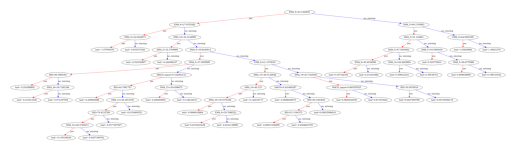

In [22]:
#plt.figure(figsize=(50, 30))  # Adjust the figure size as needed
plotted_tree=plot_tree(model, num_trees=0) # AC #chatgpt
plt.savefig('tree_plot.png', dpi=600)  # Save the figure to a file

Plot importance of every feature to the regression.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

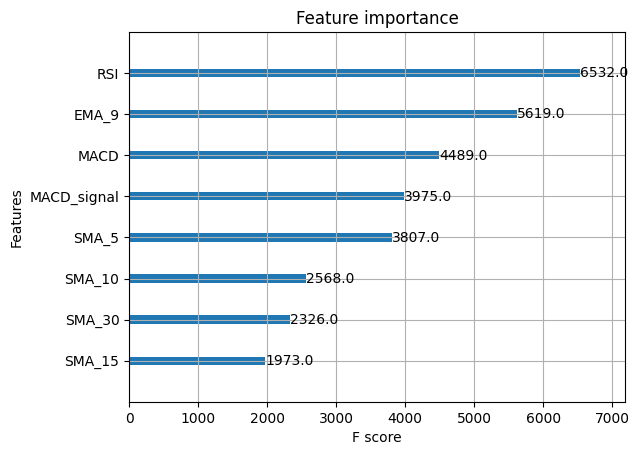

In [17]:
plot_importance(model)

In [18]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [61.48 62.11 62.37 62.98 62.75]
y_pred = [63.013386 62.48348  62.819477 63.125145 64.03203 ]


Evaluate on test set.

In [19]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


mean_squared_error = 3.077912487024458


In [20]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)
fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)
fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)
fig.show()